# Modelling and Evaluation

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set working directory

In [2]:
cwd = os.getcwd()
cwd

'/workspaces/mildew-detector/jupyter_notebooks'

In [4]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

---

## Set input directories

* Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [8]:
labels = os.listdir(train_path)

print(
    f"Image labels are: {labels}"
    )

Image labels are: ['healthy', 'powdery_mildew']


## Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image count in train, validation and test data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




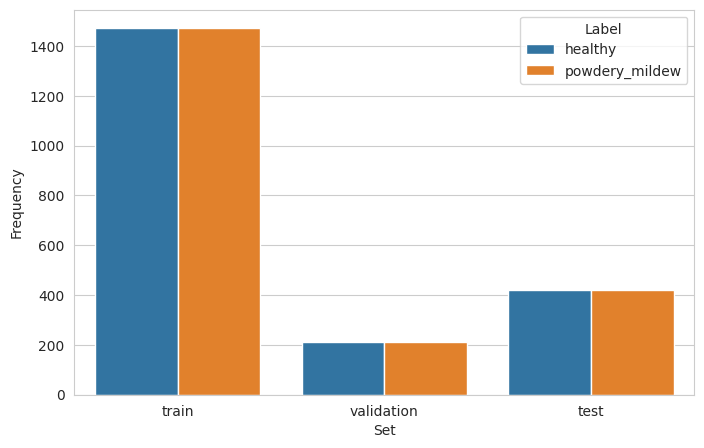

In [10]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

### Import ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Set batch size

In [13]:
batch_size = 16

### Augment and plot training image dataset

In [14]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


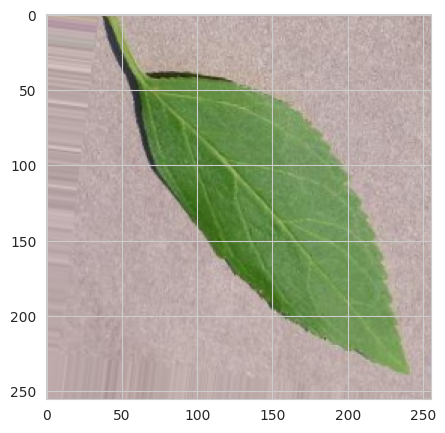

(16, 256, 256, 3)


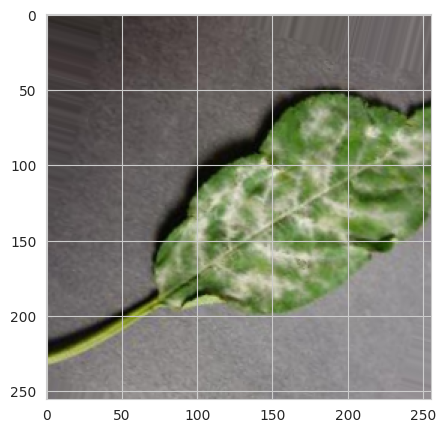

(16, 256, 256, 3)


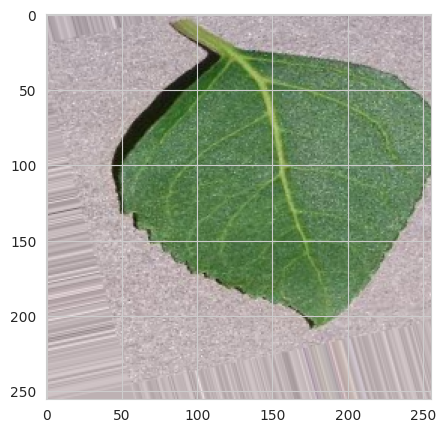

In [15]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment and plot validation image dataset

In [16]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


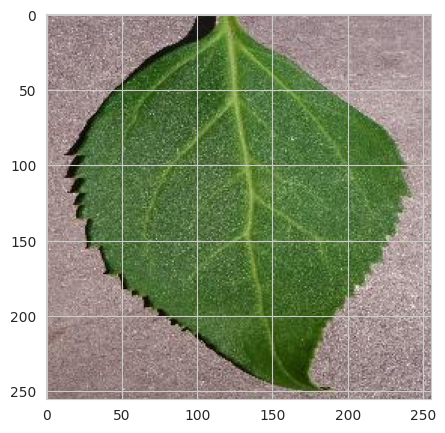

(16, 256, 256, 3)


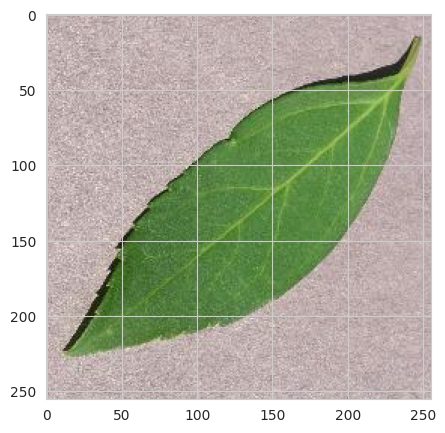

(16, 256, 256, 3)


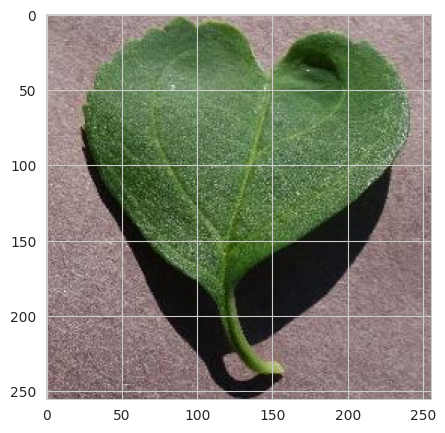

In [17]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment and plot test image dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


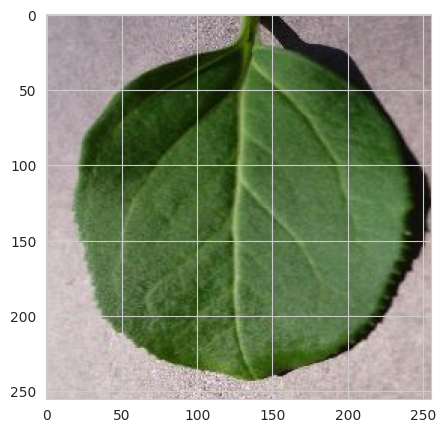

(16, 256, 256, 3)


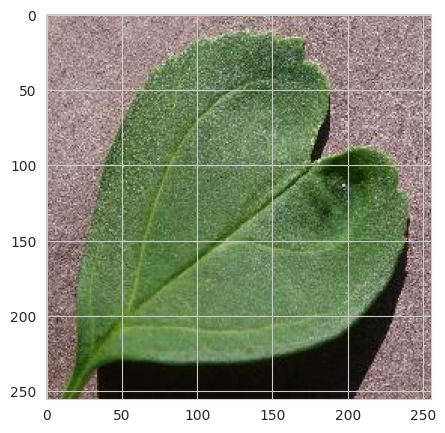

(16, 256, 256, 3)


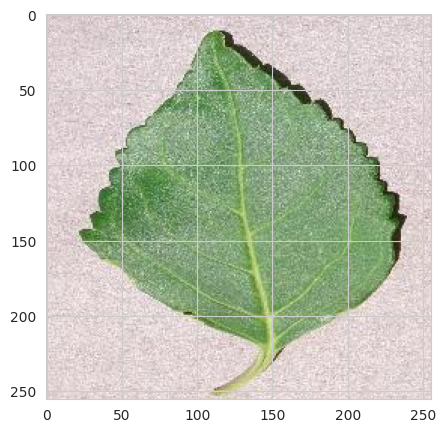

In [19]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [20]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation

### Import model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization

### Model

In [22]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])
    
    return model

### Model summary

In [23]:
create_tf_model().summary()

2023-06-07 13:46:11.071870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

### Early stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Fit model for training

In [25]:
model = create_tf_model()
model.fit(train_set,
          epochs=9,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-06-07 13:47:10.127263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/9
184/184 [==============================] - 292s 2s/step - loss: 0.5185 - accuracy: 0.7473 - val_loss: 0.3160 - val_accuracy: 0.8619
Epoch 2/9
184/184 [==============================] - 280s 2s/step - loss: 0.3313 - accuracy: 0.8590 - val_loss: 0.4331 - val_accuracy: 0.7905
Epoch 3/9
184/184 [==============================] - 286s 2s/step - loss: 0.2683 - accuracy: 0.8865 - val_loss: 0.1994 - val_accuracy: 0.9119
Epoch 4/9
184/184 [==============================] - 277s 2s/step - loss: 0.2292 - accuracy: 0.9049 - val_loss: 0.1733 - val_accuracy: 0.9405
Epoch 5/9
184/184 [==============================] - 270s 1s/step - loss: 0.1992 - accuracy: 0.9232 - val_loss: 0.1350 - val_accuracy: 0.9429
Epoch 6/9
184/184 [==============================] - 264s 1s/step - loss: 0.1679 - accuracy: 0.9399 - val_loss: 0.1260 - val_accuracy: 0.9405
Epoch 7/9
184/184 [==============================] - 271s 1s/step - loss: 0.1354 - accuracy: 0.9545 - val_loss: 0.1237 - val_accuracy: 0.9429
Epoch 

### Save model